<a href="https://colab.research.google.com/github/edsonportosilva/OpticalCommunications/blob/main/jupyter notebooks/8. Introdução às comunicações ópticas coerentes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
if 'google.colab' in str(get_ipython()):    
    ! git clone -b main https://github.com/edsonportosilva/OptiCommPy
    from os import chdir as cd
    cd('/content/OptiCommPy/')
    ! pip install .

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sympy import Matrix, zeros
from numpy.random import normal
from commpy.utilities  import upsample
from optic.dsp import firFilter, pulseShape, lowPassFIR, symbolSync
from optic.metrics import signal_power
from optic.plot import eyediagram
from optic.equalization import edc, mimoAdaptEqualizer
from optic.carrierRecovery import cpr, fourthPowerFOE
from optic.models import mzm, linFiberCh, iqm, ssfm, edfa, phaseNoise, coherentReceiver

from numpy.fft import fft, ifft, fftshift, ifftshift, fftfreq
from tqdm.notebook import tqdm
from scipy import signal
import scipy.constants as const
import numba

In [3]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize
from IPython.display import display, Math

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [4]:
%matplotlib inline
#figsize(7, 2.5)
figsize(10, 3)

In [5]:
import sympy as sp
from utils import symdisp, symplot

In [6]:
%load_ext autoreload
%autoreload 2

# Introdução às Comunicações Ópticas Coerentes

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Por-que-comunicações-ópticas-coerentes?" data-toc-modified-id="Por-que-comunicações-ópticas-coerentes?-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Por que comunicações ópticas coerentes?</a></span></li><li><span><a href="#Transmissão-de-formatos-de-modulação-coerentes" data-toc-modified-id="Transmissão-de-formatos-de-modulação-coerentes-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Transmissão de formatos de modulação coerentes</a></span></li><li><span><a href="#Detecção-coerente-de-sinais-ópticos" data-toc-modified-id="Detecção-coerente-de-sinais-ópticos-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Detecção coerente de sinais ópticos</a></span><ul class="toc-item"><li><span><a href="#Receptor-IM/DD" data-toc-modified-id="Receptor-IM/DD-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Receptor IM/DD</a></span></li><li><span><a href="#Receptor-coerente" data-toc-modified-id="Receptor-coerente-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Receptor coerente</a></span></li></ul></li><li><span><a href="#Batimento-entre-sinal-e-laser-oscilador-local-(LO)" data-toc-modified-id="Batimento-entre-sinal-e-laser-oscilador-local-(LO)-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Batimento entre sinal e laser oscilador local (LO)</a></span><ul class="toc-item"><li><span><a href="#Batimentos-entre-um-sinal-e-um-oscilador-local" data-toc-modified-id="Batimentos-entre-um-sinal-e-um-oscilador-local-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Batimentos entre um sinal e um oscilador local</a></span></li><li><span><a href="#Potência-do-sinal-detectado-$s(t)$" data-toc-modified-id="Potência-do-sinal-detectado-$s(t)$-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Potência do sinal detectado $s(t)$</a></span></li></ul></li><li><span><a href="#Híbrida-$2\times-4$-90°" data-toc-modified-id="Híbrida-$2\times-4$-90°-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Híbrida $2\times 4$ 90°</a></span><ul class="toc-item"><li><span><a href="#Exemplo-de-um-circuito-fotônico-que-implementa-uma-híbrida" data-toc-modified-id="Exemplo-de-um-circuito-fotônico-que-implementa-uma-híbrida-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Exemplo de um circuito fotônico que implementa uma híbrida</a></span></li><li><span><a href="#Matriz-de-transferência-entrada-saída" data-toc-modified-id="Matriz-de-transferência-entrada-saída-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Matriz de transferência entrada-saída</a></span></li><li><span><a href="#Derivação-das-expressões-para-o-front-end-coerente" data-toc-modified-id="Derivação-das-expressões-para-o-front-end-coerente-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Derivação das expressões para o front-end coerente</a></span></li><li><span><a href="#Tipos-de-detecção-óptica-coerente" data-toc-modified-id="Tipos-de-detecção-óptica-coerente-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Tipos de detecção óptica coerente</a></span></li></ul></li><li><span><a href="#Exemplo:-detecção-coerente-de-um-laser-não-modulado" data-toc-modified-id="Exemplo:-detecção-coerente-de-um-laser-não-modulado-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Exemplo: detecção coerente de um laser não-modulado</a></span></li><li><span><a href="#Transmissão-óptica-coerente" data-toc-modified-id="Transmissão-óptica-coerente-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Transmissão óptica coerente</a></span><ul class="toc-item"><li><span><a href="#Exemplo:-simulação-10G-OOK-vs-10G-BPSK" data-toc-modified-id="Exemplo:-simulação-10G-OOK-vs-10G-BPSK-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Exemplo: simulação 10G OOK vs 10G BPSK</a></span></li><li><span><a href="#Exemplo:-simulação-com-formatos-QPSK,-QAM" data-toc-modified-id="Exemplo:-simulação-com-formatos-QPSK,-QAM-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Exemplo: simulação com formatos QPSK, QAM</a></span></li></ul></li><li><span><a href="#Multiplexação-de-polarização" data-toc-modified-id="Multiplexação-de-polarização-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Multiplexação de polarização</a></span></li><li><span><a href="#Sistemas-WDM-coerentes" data-toc-modified-id="Sistemas-WDM-coerentes-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Sistemas WDM coerentes</a></span></li></ul></div>

## Por que comunicações ópticas coerentes?

* Receptores com melhor sensitividade.

* Laser sintonizáveis podem ser utilizados para detecção coerente em sistemas WDM.

* Possibilidade de compensação via DSP de efeitos distorcivos do canal óptico (dispersão cromática, PMD, etc).

* Uso de técnicas avançadas de modulação e codificação.

* Maior eficiência no uso do espectro disponível na fibra.

## Transmissão de formatos de modulação coerentes

<img src="./figuras/Tx_IQM.png" width="400">

## Detecção coerente de sinais ópticos

### Receptor IM/DD
<img src="./figuras/Rx_OOK.png" width="400">

### Receptor coerente
<img src="./figuras/hibrida_4x90.png" width="650">

In [7]:
t, ω_c, ω_lo, ϕ_lo, Δω, Δϕ = sp.symbols('t, ω_c, ω_{LO}, ϕ_{LO}, Δω, Δϕ', real=True)
P_s, P_lo, R = sp.symbols('P_s, P_{LO}, R_d', real=True, positive=True)

A = sp.Function('A', real=True)(t)
ϕ = sp.Function('ϕ', real=True)(t)

π = sp.pi
j = sp.I

**Campo elétrico da portadora óptica modulada $E_s(t)$**

In [8]:
E_s = sp.sqrt(P_s)*A*sp.exp(j*(ω_c*t + ϕ))

symdisp('E_s(t) =', E_s)

<IPython.core.display.Math object>

**Campo elétrico do laser oscilador local $E_{LO}(t)$**

In [9]:
E_lo = sp.sqrt(P_lo)*sp.exp(j*(ω_lo*t + ϕ_lo))

symdisp('E_{LO}(t) =', E_lo)

<IPython.core.display.Math object>

## Batimento entre sinal e laser oscilador local (LO)

$$
\begin{aligned}
I_1(t) &= R_d\left|E_s(t) + jE_{LO}(t) \right|^2 \nonumber\\
       &= R_d\left[E_s(t) + jE_{LO}(t) \right]\left[E_s^*(t) - jE_{LO}^*(t) \right] \nonumber\\
       &= R_d\left[E_s(t)E_s^*(t) + jE_{LO}(t)E_s^*(t) - jE_s(t)E_{LO}^*(t) -j^2E_{LO}(t)E_{LO}^*(t) \right] \nonumber\\
       &= R_d\left[A^2P_s + jE_{LO}(t)E_s^*(t) - jE_s(t)E_{LO}^*(t) + P_{LO}\right] \nonumber\\
       &= R_d\left[A^2P_s + P_{LO}\right] + R_d\left[ jE_{LO}(t)E_s^*(t) +(jE_{LO}(t)E_s^*(t))^* \right] \nonumber\\
       &= R_d\left[A^2P_s + P_{LO}\right] + R_d 2\operatorname{Re}\left[jE_{LO}(t)E_s^*(t)\right] \nonumber\\
       &= R_d\left[A^2P_s + P_{LO}\right] + 2R_d\operatorname{Re}\left[j\sqrt{P_{LO}}e^{j(ω_{LO}t + ϕ_{LO})}A\sqrt{P_{s}}e^{-j(ω_ct + ϕ)}\right] \nonumber\\
       &= R_d\left[A^2P_s + P_{LO}\right] + 2R_dA\sqrt{P_{LO}}\sqrt{P_{s}}\operatorname{Re}\left[je^{j(ω_{LO}t + ϕ_{LO})}e^{-j(ω_ct + ϕ)}\right] \nonumber\\
       &= R_d\left[A^2P_s + P_{LO}\right] + 2R_dA\sqrt{P_{LO}}\sqrt{P_{s}}\operatorname{Re}\left[e^{j(ω_{LO}t -ω_ct + ϕ_{LO}- ϕ + \pi/2)}\right] \nonumber\\
       &= R_d\left[A^2P_s + P_{LO}\right] + 2R_dA\sqrt{P_{LO}}\sqrt{P_{s}}\cos(ω_{LO}t -ω_ct + ϕ_{LO}- ϕ + \pi/2) \nonumber\\
       &= R_d\left[A^2P_s + P_{LO}\right] - 2R_dA\sqrt{P_{LO}}\sqrt{P_{s}}\operatorname{sen}(ω_{LO}t -ω_ct + ϕ_{LO} - ϕ) \nonumber\\
       &= R_d\left[A^2P_s + P_{LO}\right] + 2R_dA\sqrt{P_{LO}}\sqrt{P_{s}}\operatorname{sen}(ω_ct - ω_{LO}t + ϕ - ϕ_{LO}) \nonumber\\
       &= R_d\left[A^2P_s + P_{LO}\right] + 2R_dA\sqrt{P_{LO}}\sqrt{P_{s}}\operatorname{sen}(\Delta ωt + \Delta \phi) \nonumber\\
\end{aligned}
$$

em que $\Delta \omega = \omega_c - \omega_{LO}$ e $\Delta \phi = \phi - \phi_{LO}$.

### Batimentos entre um sinal e um oscilador local

**Fotocorrente $i_1(t)\propto |E_s + jE_{LO}|^2$**

In [10]:
Ei1 = (E_s + j*E_lo)/2

symdisp('E_{i_1}(t) =', Ei1)

i1 = R*sp.Abs(Ei1)**2

i1 = sp.re(i1).simplify().expand()

symdisp('i_1(t) =', i1)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

**Fotocorrente $i_2(t) \propto |E_s - jE_{LO}|^2$**

In [11]:
Ei2 = (E_s - j*E_lo)/2

symdisp('E_{i_2}(t) =', Ei2)

i2 = R*sp.Abs(Ei2)**2

i2 = sp.re(i2).simplify().expand()

symdisp('i_2(t) =', i2)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

**Corrente $s_Q(t) = i_1(t)-i_2(t)$**

In [12]:
sQ = i1 - i2 # saída do fotodetector balanceado

sQ = sQ.simplify()

symdisp('s_Q(t) =', sQ)

<IPython.core.display.Math object>

**Fotocorrente $i_3(t) \propto |E_s + E_{LO}|^2$**

In [13]:
Ei3 = (E_s + E_lo)/2

symdisp('E_{i_3}(t) =', Ei3)

i3 = R*sp.Abs(Ei3)**2

i3 = sp.re(i3).simplify().expand()

symdisp('i_3(t) =', i3)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

**Fotocorrente $i_4(t) \propto |E_s - E_{LO}|^2$**

In [14]:
Ei4 = (E_s - E_lo)/2

symdisp('E_{i_4}(t) =', Ei4)

i4 = R*sp.Abs(Ei4)**2

i4 = sp.re(i4).simplify().expand()

symdisp('i_4(t) =', i4)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

**Corrente $s_I(t) = i_3(t)-i_4(t)$**

In [15]:
sI = i3 - i4 # saída do fotodetector balanceado

sI = sI.simplify()

symdisp('s_I(t) =', sI)

<IPython.core.display.Math object>

**Sinal complexo detectado $s(t) = s_I(t) + js_Q(t)$**

In [16]:
s = sI + j*sQ

s = s.simplify()

symdisp('s(t) =', s)

<IPython.core.display.Math object>

### Potência do sinal detectado $s(t)$

In [17]:
Pr = sp.Abs(s)**2 # potência do sinal s(t)

symdisp('P_r(t) =', Pr)

<IPython.core.display.Math object>

## Híbrida $2\times 4$ 90°

### Exemplo de um circuito fotônico que implementa uma híbrida

<img src="./figuras/hibrida_PIC.png" width="400">

### Matriz de transferência entrada-saída

$$M=\left[\begin{array}{cccc}\frac{\sqrt{2}}{2} & \frac{\sqrt{2} j}{2} & 0 & 0 \\ \frac{\sqrt{2} j}{2} & \frac{\sqrt{2}}{2} & 0 & 0 \\ 0 & 0 & \frac{\sqrt{2}}{2} & \frac{\sqrt{2 j}}{2} \\ 0 & 0 & \frac{\sqrt{2} j}{2} & \frac{\sqrt{2}}{2}\end{array}\right]$$

$$
U=\left[\begin{array}{llll}
1 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 0 & i
\end{array}\right]
$$

$$ T = MUM $$

### Derivação das expressões para o front-end coerente

**Matriz de transferência do acoplador 3dB**

In [18]:
C_3dB  = 1/sp.sqrt(2)*Matrix([[1, j],[j, 1]])

symdisp('C_{3dB} = ', C_3dB)

<IPython.core.display.Math object>

**Matriz de transferência da híbrida $2\times4$ 90°**

In [19]:
M = Matrix([[C_3dB, zeros(2)], [zeros(2), C_3dB]])
U = Matrix([[1, 0, 0, 0],[0, 0, 1, 0],[0, 1, 0, 0],[0, 0, 0, j]])

symdisp('M = ', M)
symdisp('U = ', U)
symdisp('T = MUM = ', M*U*M)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

**Derivação das expressões do *front-end* coerente com o Sympy**

In [20]:
# define funções do sympy para auxílio na derivação das expressões

# híbrida
def hybrid_2x4_90(E1, E2):
    
    M = Matrix([[C_3dB, zeros(2)], 
                [zeros(2), C_3dB]])
    
    U = Matrix([[1, 0, 0, 0],
                [0, 0, 1, 0],
                [0, 1, 0, 0],
                [0, 0, 0, j]])
    
    Ei = Matrix([[E1],[0],[0],[E2]]) # vetor 4x1
    
    Eo = M*U*M*Ei 
    
    return Eo    

# fotodetector balanceado
def bpd(E1, E2, R=1):
    
    i1 = sp.Abs(E1)**2 # |E1|^2
    i2 = sp.Abs(E2)**2 # |E2|^2
    i = i1 - i2
    
    return R*sp.re(i).simplify().expand()

In [21]:
Eo = hybrid_2x4_90(E_s, E_lo)

print('Entrada óptica da híbrida:')
symdisp('E_i = ', Matrix([[E_s],[0],[0],[E_lo]]))

Entrada óptica da híbrida:


<IPython.core.display.Math object>

In [22]:
print('Saída óptica da híbrida:')
symdisp('E_o = ', Eo)

Saída óptica da híbrida:


<IPython.core.display.Math object>

**Fotodetecção balanceada**

In [23]:
sI = bpd(Eo[1], Eo[0], R) # fotodeteccão balanceada de Eo[1] e Eo[0]
sQ = bpd(Eo[2], Eo[3], R) # fotodeteccão balanceada de Eo[2] e Eo[3]

symdisp('s_I = ', sI)
symdisp('s_Q = ', sQ)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

**Campo elétrico recuperado**

In [24]:
s  = sI + j*sQ
s  = s.simplify()

symdisp('s = ', s)

<IPython.core.display.Math object>

In [25]:
s = s.subs({ω_lo:ω_c + Δω, ϕ:ϕ_lo + Δϕ})

s = s.simplify().doit()

symdisp('s = ', s)

<IPython.core.display.Math object>

### Tipos de detecção óptica coerente

* **Detecção homódina (*homodyne detection*)**($\Delta\omega = 0$): a frequência do laser do transmissor e a frequência do laser oscilador local são idênticas.

* **Detecção heteródina (*heterodyne detection*)**($\Delta\omega \neq 0$): a frequência do laser do transmissor e a frequência do laser oscilador local são diferentes.

* **Detecção intradina (*intradyne detection*)**($\Delta\omega \approx 0$): a frequência do laser do transmissor e do laser oscilador local são "ligeiramente" diferentes.

**Assumindo coerência perfeita entre os lasers do transmissor e do receptor($Δω=0, ϕ_{LO}=0$)**

In [26]:
# assumindo que portadora e oscilador local estão sincronizados em fase e frequência
s = s.subs({Δω:0, Δϕ:ϕ})/(sp.sqrt(P_s)*sp.sqrt(P_lo)*R)

symdisp('s = ', s)

<IPython.core.display.Math object>

**Funções para modelagem de um receptor coerente utilizando o numpy**

In [27]:
def balancedPD(E1, E2, R=1):
    '''
    Balanced photodetector (BPD)
    
    :param E1: input field [nparray]
    :param E2: input field [nparray]
    :param R: photodiode responsivity [scalar]
    
    :return: balanced photocurrent
    '''
    assert R > 0, 'PD responsivity should be a positive scalar'
    assert E1.size == E2.size, 'E1 and E2 need to have the same size'
    
    i1 = R*E1*np.conj(E1)
    i2 = R*E2*np.conj(E2)    

    return i1-i2

def hybrid_2x4_90deg(E1, E2):
    '''
    Optical 2 x 4 90° hybrid
    
    :param E1: input signal field [nparray]
    :param E2: input LO field [nparray]
        
    :return: hybrid outputs
    '''
    assert E1.size == E2.size, 'E1 and E2 need to have the same size'
    
    # optical hybrid transfer matrix    
    T = np.array([[ 1/2,  1j/2,  1j/2, -1/2],
                  [ 1j/2, -1/2,  1/2,  1j/2],
                  [ 1j/2,  1/2, -1j/2, -1/2],
                  [-1/2,  1j/2, -1/2,  1j/2]])
    
    Ei = np.array([E1, np.zeros((E1.size,)), 
                   np.zeros((E1.size,)), E2])    
    
    Eo = T@Ei
    
    return Eo
    
def coherentReceiver(Es, Elo, Rd=1):
    '''
    Single polarization coherent optical front-end
    
    :param Es: input signal field [nparray]
    :param Elo: input LO field [nparray]
    :param Rd: photodiode resposivity [scalar]
    
    :return: downconverted signal after balanced detection    
    '''
    assert Rd > 0, 'PD responsivity should be a positive scalar'
    assert Es.size == Elo.size, 'Es and Elo need to have the same size'
    
    # optical 2 x 4 90° hybrid 
    Eo = hybrid_2x4_90deg(Es, Elo)
        
    # balanced photodetection
    sI = balancedPD(Eo[1,:], Eo[0,:], Rd)
    sQ = balancedPD(Eo[2,:], Eo[3,:], Rd)
    
    return sI + 1j*sQ

In [28]:
def phaseNoise(lw, Nsamples, Ts):
    
    σ2 = 2*np.pi*lw*Ts    
    phi = np.zeros(Nsamples)
    
    for ind in range(0, Nsamples-1):
        phi[ind+1] = phi[ind] + normal(0, np.sqrt(σ2))
        
    return phi

## Exemplo: detecção coerente de um laser não-modulado

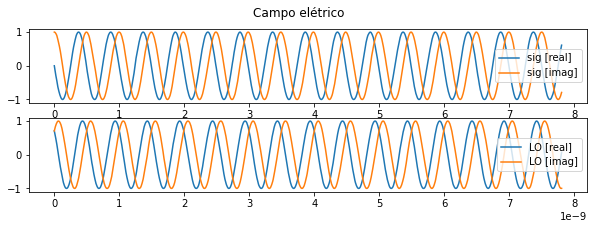

In [29]:
# parâmetros da simulação
Fa     = 128e9    # Frequência de amostragem do sinal
Ta     = 1/Fa     # Período de amostragem

Nsamples = 1000

#Pi_dBm = 10  # potência de sinal óptico na entrada do modulador em dBm
π = np.pi

#
lw = 1e6
pn_sig = phaseNoise(lw, Nsamples, Ta)
pn_lo  = phaseNoise(lw, Nsamples, Ta)

# parâmetros do sinal
Pin   = 1     # potência do laser
f_sig = 2e9   # frequência do sinal
ϕs    = π/2   # fase do laser

# parâmetros do oscilador local
Plo  = 1    # potência do oscilador local na entrada do receptor
f_lo = 2e9  # frequência do oscilador local
ϕ_lo = π/4    # fase do oscilador local

############# Simulação #############

# oscilador local
t     = np.arange(0, Nsamples)*Ta
sig   = np.sqrt(Pin)*np.exp(1j*(2*π*f_sig*t + ϕs   + pn_sig))*np.ones(t.size) # campo elétrico do sinal
sigLO = np.sqrt(Plo)*np.exp(1j*(2*π*f_lo*t + ϕ_lo + pn_lo)) # campo elétrico do oscilador local

fig, axs = plt.subplots(2)
fig.suptitle('Campo elétrico')
axs[0].plot(t, sig.real, label = 'sig [real]')
axs[0].plot(t, sig.imag, label = 'sig [imag]')
axs[0].legend();
axs[1].plot(t, sigLO.real, label = 'LO [real]')
axs[1].plot(t, sigLO.imag, label = 'LO [imag]');
axs[1].legend();

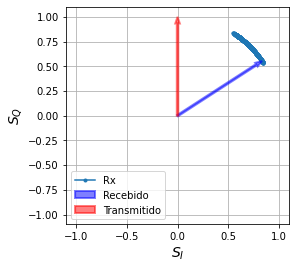

In [30]:
# receptor coerente
sigRx = coherentReceiver(sig, sigLO)

plt.figure(figsize=(4,4))
plt.plot(sigRx.real,sigRx.imag,'o-', markersize=3, label='Rx')
plt.ylabel('$S_Q$', fontsize=14)
plt.xlabel('$S_I$', fontsize=14)
plt.xlim(-1.1,1.1)
plt.ylim(-1.1,1.1)
plt.grid()

plt.arrow(0, 0, sigRx[-1].real,sigRx[-1].imag, length_includes_head=True, shape ='full',
                                         alpha = 0.5, width = 0.015, edgecolor = 'blue', 
                                         facecolor = 'blue', lw = 2, zorder = 5, label='Recebido')

plt.arrow(0, 0, sig[0].real,sig[0].imag, length_includes_head=True, shape ='full',
                                         alpha = 0.5, width = 0.015, edgecolor = 'red', 
                                         facecolor = 'red', lw = 2, zorder = 5, label='Transmitido')
plt.legend(loc='lower left');

## Transmissão óptica coerente

<img src="./figuras/sistemaCoerente.png" width="1000">

### Exemplo: simulação 10G OOK vs 10G BPSK

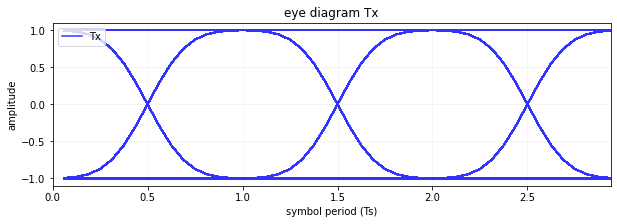

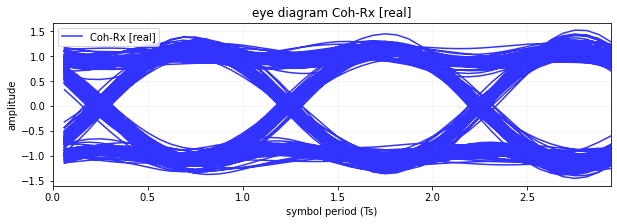

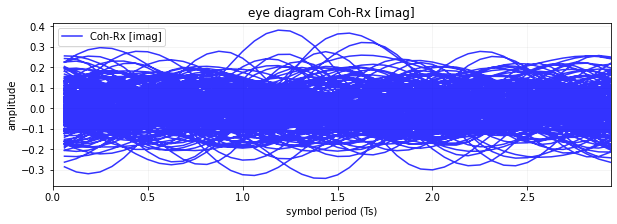

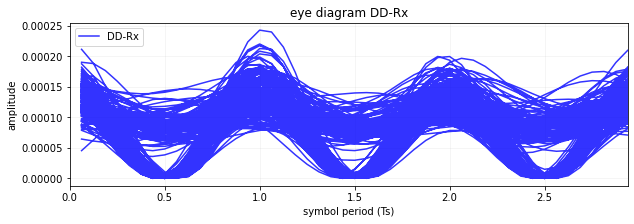

P_sig[opt] = -10.56 dBm
P_ase[opt] = -26.98 dBm
OSNR[est,Bsig] = 16.32 dB 

SNR[est] = 17.44 dB 

Total de erros contados = 0  
BER = 0.00e+00  


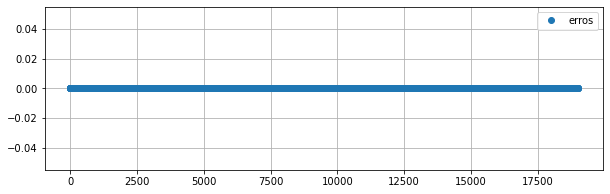

In [31]:
modulation = 'BPSK' # 'OOK', 'BPSK'

# parâmetros da simulação
SpS    = 16            # número de amostras por símbolo
Rs     = 10e9          # Taxa de símbolos (para o caso do OOK Rs = Rb)
Ts     = 1/Rs          # Período de símbolo em segundos
Fa     = 1/(Ts/SpS)    # Frequência de amostragem do sinal (amostras/segundo)
Ta     = 1/Fa          # Período de amostragem

π = np.pi

# parâmetros do MZM
Vπ = 2

if modulation == 'OOK':
    Vb  = -Vπ/2
    Amp = 1
    Pi_dBm = -10+3.5  # potência de sinal óptico na entrada do modulador em dBm
elif modulation == 'BPSK':
    Vb = -Vπ
    Amp = 2
    Pi_dBm = -10  # potência de sinal óptico na entrada do modulador em dBm
    
Pi = 10**(Pi_dBm/10)*1e-3 # potência de sinal óptico em W na entrada do MZM

# parâmetros do receptor
B   = 10e9      # banda do receptor em Hz
Plo_dBm  = 10   # potência do oscilador local
Δf_lo = 0       # desvio de frequência do oscilador local
ϕ_lo  = 0       # fase do oscilador local

Plo = 10**(Plo_dBm/10)*1e-3 # potência do oscilador local na entrada do receptor



############# Simulação #############

### Transmissor

# gera sequência de bits pseudo-aleatórios
bitsTx   = np.random.randint(2, size=20000)    
n        = np.arange(0, bitsTx.size)

# mapeia bits para pulsos elétricos
symbTx = 2*bitsTx-1
symbTx = symbTx/np.sqrt(signal_power(symbTx))

# upsampling
symbolsUp = upsample(symbTx, SpS)

# pulso
pulse = pulseShape('nrz', SpS)
pulse = pulse/max(abs(pulse))

# formatação de pulso
sigTx  = firFilter(pulse, symbolsUp)

# modulação óptica
Ai      = np.sqrt(Pi)
sigTxo_ = mzm(Ai, Amp*sigTx, Vπ, Vb)

# adiciona ruído ASE ao sinal óptico
σASE  = 1e-6#1e-5
ruido = normal(0, np.sqrt(Fa*(σASE/(2*B))), sigTxo_.size) + 1j*normal(0, np.sqrt(Fa*(σASE/(2*B))), sigTxo_.size)

sigTxo = sigTxo_ + ruido

### Recepcão coerente
Pin = (np.abs(sigTxo)**2).mean() # Potência óptica média média recebida

# oscilador local
t     = np.arange(0, sigTxo.size)*Ta
sigLO = np.sqrt(Plo)*np.exp(1j*(2*π*Δf_lo*t + ϕ_lo))

# receptor coerente
sigRx = coherentReceiver(sigTxo, sigLO)
sigRx = sigRx/np.std(sigRx)

# filtragem Rx
N = 8001
h = lowPassFIR(B, Fa, N, typeF='rect')
sigRx = firFilter(h, sigRx)

# calculando a OSNR na simulação
sigTxo_Rx   = firFilter(h, sigTxo_)
sigTxo_DDRx = firFilter(h, sigTxo)
ruido_Rx    = firFilter(h, ruido)

OSNR = signal_power(sigTxo_Rx)/signal_power(ruido_Rx)

Nsamples = 10000

sigEye = sigRx.copy()
eyediagram(sigTx,  Nsamples, SpS, plotlabel = 'Tx')
eyediagram(sigEye[int(h.size/SpS)::], Nsamples, SpS, plotlabel = 'Coh-Rx')
eyediagram(np.abs(sigTxo_DDRx)**2, Nsamples, SpS, plotlabel = 'DD-Rx')

# captura amostras no meio dos intervalos de sinalização
sigRx = sigRx[0::SpS]
sigRx = sigRx/np.sqrt(signal_power(sigRx))

if modulation == 'OOK':
    symbTx = (symbTx+1)/np.sqrt(signal_power(symbTx+1))
    
# Aplica a regra de decisão ótima
bitsRx = np.empty(bitsTx.size)
bitsRx[sigRx> symbTx.mean()] = 1
bitsRx[sigRx<= symbTx.mean()] = 0

discard = 500
ind = np.arange(discard, sigRx.size-discard)

# estima SNR do sinal recebido: SNR = Es/σ^2
SNR = 1/signal_power(sigRx[ind]-symbTx[ind])

err = np.logical_xor(bitsRx[ind], 
                     bitsTx[ind])
BER = np.mean(err)

print('P_sig[opt] = %.2f dBm'%(10*np.log10(signal_power(sigTxo_)/1e-3)))
print('P_ase[opt] = %.2f dBm'%(10*np.log10(signal_power(ruido_Rx)/1e-3)))
print('OSNR[est,Bsig] = %.2f dB \n'%(10*np.log10(OSNR)))
print('SNR[est] = %.2f dB \n'%(10*np.log10(SNR)))
print('Total de erros contados = %d  '%(err.sum()))
print('BER = %.2e  '%(BER))

plt.figure()
plt.plot(err,'o', label = 'erros')
plt.legend()
plt.grid()

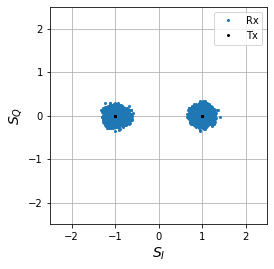

In [32]:
plt.figure(figsize=(4,4))
plt.axis('square')
plt.ylabel('$S_Q$', fontsize=14)
plt.xlabel('$S_I$', fontsize=14)
plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)
plt.grid()

plt.plot(sigRx[ind].real,sigRx[ind].imag,'.', markersize=4, label='Rx')
plt.plot(symbTx[ind].real,symbTx[ind].imag,'k.', markersize=4, label='Tx')
plt.legend();

### Exemplo: simulação com formatos QPSK, QAM

**Modulador óptico IQ**

In [33]:
from optic.modulation import modulateGray, demodulateGray, GrayMapping
from optic.dsp import pnorm, decimate
from optic.models import linFiberCh
from optic.core import parameters

P_sig[opt] = -11.38 dBm
P_ase[opt] = -63.96 dBm
OSNR[est] = -46.44 dB 

SNR[est] = 38.60 dB 

Total de erros contados = 0  
BER = 0.00e+00  


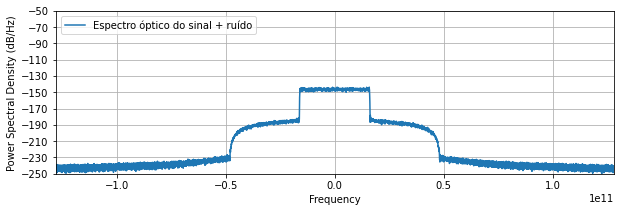

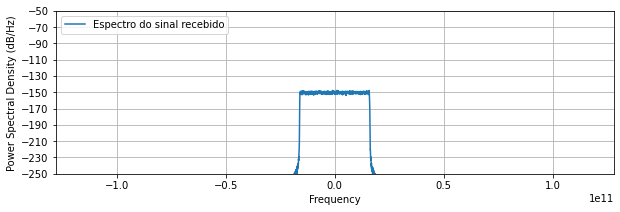

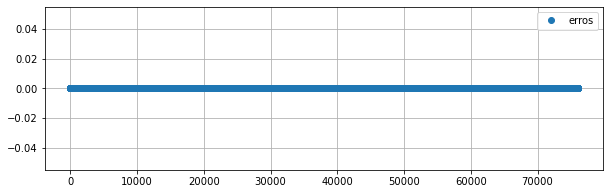

In [34]:
plotEyeDiagrams = False
plotPSD         = True

# parâmetros da simulação
M      = 16
SpS    = 16            # número de amostras por símbolo
Rs     = 32e9          # Taxa de símbolos 
Ts     = 1/Rs          # Período de símbolo em segundos
Fa     = 1/(Ts/SpS)    # Frequência de amostragem do sinal (amostras/segundo)
Ta     = 1/Fa          # Período de amostragem

Pi_dBm = 0  # potência de sinal óptico na entrada do modulador em dBm
π = np.pi

# parâmetros do IQM
Vπ = 2
Vb = -Vπ
Pi = 10**(Pi_dBm/10)*1e-3 # potência de sinal óptico em W na entrada do MZM

# parâmetros do canal óptico
Ltotal = 20     # km
alpha = 0.2    # dB/km
D = 16         # ps/nm/km
Fc = 193.1e12  # Hz

# parâmetros do receptor
B  = 32e9     # banda do receptor em Hz

Plo_dBm  = 10    # potência do oscilador local
Δf_lo    = 0     # desvio de frequência do oscilador local
ϕ_lo     = 0     # fase do oscilador local
lw       = 0*10e3

Plo = 10**(Plo_dBm/10)*1e-3 # potência do oscilador local na entrada do receptor




############# Simulação #############

### Transmissor

# gera sequência de bits pseudo-aleatórios
bitsTx   = np.random.randint(2, size=80000)    

# mapeia bits para símbolos QAM
symbTx = modulateGray(bitsTx, M, 'qam')

# normaliza energia média dos símbolos para 1
symbTx = pnorm(symbTx)

# upsampling
symbolsUp = upsample(symbTx, SpS)

# pulso
#pulse = pulseShape('nrz', SpS)
pulse = pulseShape('rrc', SpS, N=4096, alpha=0.01, Ts=Ts)
pulse = pulse/np.max(np.abs(pulse))

# formatação de pulso
sigTx  = firFilter(pulse, symbolsUp)

# modulação óptica
Ai      = np.sqrt(Pi)
sigTxo_ = iqm(Ai, 0.5*sigTx, Vπ, Vb, Vb)
    
# adiciona ruído ASE ao sinal óptico
σ2ASE  = 1e-10
σ2 = σ2ASE*(Fa/B)
ruido = normal(0, np.sqrt(σ2), sigTxo_.size) + 1j*normal(0, np.sqrt(σ2), sigTxo_.size)

sigTxo = sigTxo_ + 0*ruido

# calculando a OSNR na simulação
OSNR = signal_power(sigTxo_)/(σ2ASE*B)

# plota psd
if plotPSD:
    plt.figure();
    plt.ylim(-250,-50);
    plt.psd(sigTxo, Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro óptico do sinal + ruído')
    plt.legend(loc='upper left');
    plt.xlim(-4*Rs,4*Rs);

### Canal óptico linear
sigRxo = linFiberCh(sigTxo, Ltotal, alpha, D, Fc, Fa)

### Recepcão coerente
Pin = (np.abs(sigTxo)**2).mean() # Potência óptica média média recebida

# oscilador local
t      = np.arange(0, sigRxo.size)*Ta
ϕ_pn_lo  = phaseNoise(lw, sigRxo.size, Ta)

sigLO = np.sqrt(Plo)*np.exp(1j*(2*π*Δf_lo*t + ϕ_lo + ϕ_pn_lo))

# receptor coerente
sigRx = coherentReceiver(sigRxo, sigLO)

# filtragem Rx
sigRx = firFilter(pulse, sigRx)

# plota psd
if plotPSD:
    plt.figure();
    plt.ylim(-250,-50);
    plt.psd(sigRx, Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal recebido')
    plt.legend(loc='upper left');
    plt.xlim(-4*Rs,4*Rs);

# calculando a OSNR na simulação
#sigTxo_Rx   = firFilter(h, sigTxo_)
sigRxo_DD = firFilter(h, sigRxo)
ruido_Rx  = firFilter(h, ruido)

Nsamples = 16000
sigEye = sigRx.copy()

#visualiza diagramas de olho
if plotEyeDiagrams:
    eyediagram(sigTx,  Nsamples, SpS, plotlabel = 'Tx')
    eyediagram(sigEye, Nsamples, SpS, plotlabel = 'Coh-Rx')
    eyediagram(np.abs(sigRxo_DD)**2, Nsamples, SpS, plotlabel = 'DD-Rx')

# compensa dispersão cromática
sigRx = edc(sigRx, Ltotal, D, Fc, Fa)

# captura amostras no meio dos intervalos de sinalização
paramDec = parameters()
paramDec.SpS_in = SpS
paramDec.SpS_out = 1
sigRx = decimate(sigRx.reshape(-1,1), paramDec).reshape(-1,)

discard = 2000
ind = np.arange(discard, sigRx.size-discard)

# normaliza constelação recebida
sigRx = pnorm(sigRx)

# compensa (possível) rotação de fase adicionada pelo canal
rot = np.mean(symbTx[ind]/sigRx[ind])
sigRx  = rot*sigRx

# estima SNR da constelação recebida
SNR = signal_power(symbTx[ind])/signal_power(sigRx[ind]-symbTx[ind])

# Aplica a regra de decisão brusca        
constSymb = GrayMapping(M, 'qam')
Es = np.mean(np.abs(constSymb) ** 2)
bitsRx = demodulateGray(np.sqrt(Es)*pnorm(sigRx), M, 'qam') 

err = np.logical_xor(bitsRx[discard:bitsRx.size-discard], 
                     bitsTx[discard:bitsTx.size-discard])
BER = np.mean(err)

print('P_sig[opt] = %.2f dBm'%(10*np.log10(signal_power(sigTxo_)/1e-3)))
print('P_ase[opt] = %.2f dBm'%(10*np.log10(signal_power(ruido_Rx)/1e-3)))
print('OSNR[est] = %.2f dB \n'%(10*np.log10(OSNR)))
print('SNR[est] = %.2f dB \n'%(10*np.log10(SNR)))
print('Total de erros contados = %d  '%(err.sum()))
print('BER = %.2e  '%(BER))

plt.figure()
plt.plot(err,'o', label = 'erros')
plt.legend()
plt.grid()

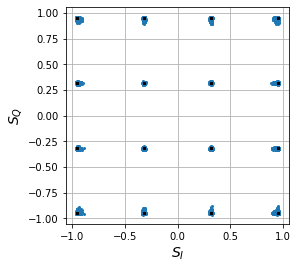

In [35]:
plt.figure(figsize=(4,4))
plt.ylabel('$S_Q$', fontsize=14)
plt.xlabel('$S_I$', fontsize=14)
#plt.xlim(-1.1,1.1)
#plt.ylim(-1.1,1.1)
plt.grid()

plt.plot(sigRx[ind].real,sigRx[ind].imag,'.', markersize=4, label='Rx')
plt.plot(symbTx[ind].real,symbTx[ind].imag,'k.', markersize=4, label='Tx');

## Multiplexação de polarização

<img src="./figuras/sistemaCoerentePM.png" width="900">

## Sistemas WDM coerentes

In [45]:
from optic.tx import simpleWDMTx

**Geração de sinal WDM**

In [46]:
# Parâmetros do transmissor:
param = parameters()
param.M   = 16           # ordem do formato de modulação
param.Rs  = 32e9         # taxa de sinalização [baud]
param.SpS = 16           # número de amostras por símbolo
param.Nbits = 80000      # número de bits
param.pulse = 'rrc'      # formato de pulso
param.Ntaps = 4096       # número de coeficientes do filtro RRC
param.alphaRRC = 0.01    # rolloff do filtro RRC
param.Pch_dBm = -4       # potência média por canal WDM [dBm]
param.Nch     = 5        # número de canais WDM
param.Fc      = 193.1e12 # frequência central do espectro WDM
param.freqSpac = 40e9    # espaçamento em frequência da grade de canais WDM
param.lw = 100e3         # largura de linha dos lasers
param.Nmodes = 1         # número de modos de polarização

sigWDM_Tx, symbTx_, paramTx = simpleWDMTx(param)

  0%|          | 0/5 [00:00<?, ?it/s]

**Transmissão via fibra SMF (split-step Fourier)**

In [47]:
canalLinear = False

# parâmetros do canal óptico
Ltotal = 800   # km
Lspan  = 80    # km
alpha = 0.2    # dB/km
D = 16         # ps/nm/km
Fc = 193.1e12  # Hz
hz = 1         # km
gamma = 1.3    # 1/(W.km)

if canalLinear:
    sigWDM = linFiberCh(sigWDM_Tx, Ltotal, alpha, D, Fc, param.Rs*param.SpS)
else:
    #powerProfile(param.Pch_dBm, alpha, Lspan, Ltotal/Lspan)
    paramCh = parameters()
    paramCh.Ltotal = Ltotal
    paramCh.Lspan = Lspan
    paramCh.alpha = alpha
    paramCh.D = D
    paramCh.Fc = Fc
    paramCh.hz = hz
    paramCh.gamma = gamma
    paramCh.amp = 'edfa'    
    
    sigWDM, paramCh = ssfm(sigWDM_Tx, param.Rs*param.SpS, paramCh) 

  0%|          | 0/10 [00:00<?, ?it/s]

**Espectro dos canais WDM antes e após a transmissão**

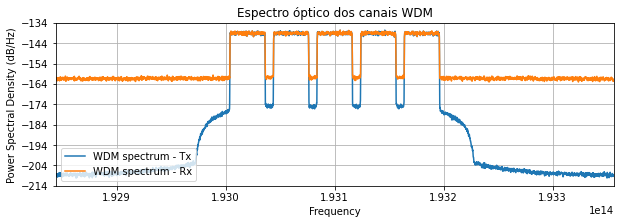

In [48]:
# plota psd
plt.figure()
plt.xlim(Fc-param.SpS*param.Rs/2,Fc+param.SpS*param.Rs/2);
plt.psd(sigWDM_Tx[:,0], Fs=param.SpS*param.Rs, Fc=Fc, NFFT = 4*1024, sides='twosided', label = 'WDM spectrum - Tx')
plt.psd(sigWDM, Fs=param.SpS*param.Rs, Fc=Fc, NFFT = 4*1024, sides='twosided', label = 'WDM spectrum - Rx')
plt.legend(loc='lower left')
plt.title('Espectro óptico dos canais WDM');

**Recepção dos canais WDM**

Demodulando canal #1 , fc: 193.0600 THz, λ: 1552.8460 nm
Oscilador local P: 10.00 dBm, lw: 100.00 kHz, FO: 128.00 MHz
FO estimado: -128.0000 MHz
SNR[est] = 20.47 dB 

Total de bits = 76000  
Total de erros contados = 0  
BER = 0.00e+00  


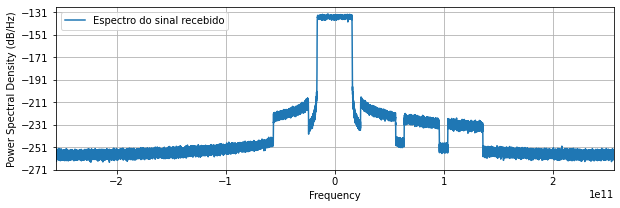

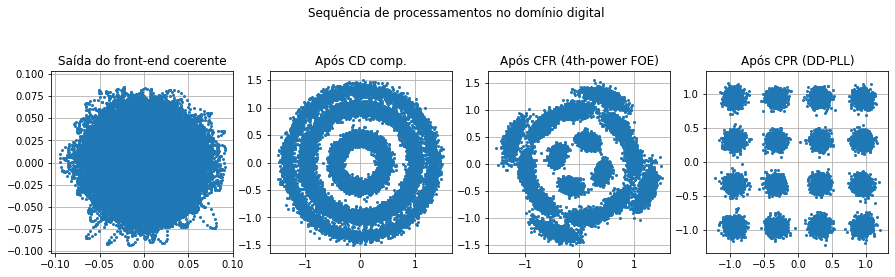

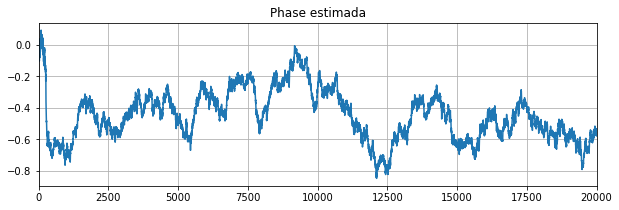

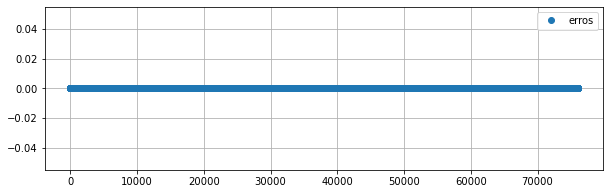

In [49]:
### Receptor

# parâmetros
chIndex = 1 # índice do canal a ser demodulado
plotPSD = True

Fa = param.SpS*param.Rs
Ta = 1/Fa

print('Demodulando canal #%d , fc: %.4f THz, λ: %.4f nm'\
      %(chIndex, (Fc + paramTx.freqGrid[chIndex])/1e12, const.c/(Fc + paramTx.freqGrid[chIndex])/1e-9))

sigWDM = sigWDM.reshape(len(sigWDM),)
symbTx = symbTx_[:,:,chIndex].reshape(len(symbTx_),)



# parâmetros do oscilador local:
FO      = 128e6                 # desvio de frequência
Δf_lo   = paramTx.freqGrid[chIndex]+FO  # downshift canal a ser demodulado
lw      = 100e3                 # largura de linha
Plo_dBm = 10                    # potência em dBm
Plo     = 10**(Plo_dBm/10)*1e-3 # potência em W
ϕ_lo    = 0                     # fase inicial em rad     

print('Oscilador local P: %.2f dBm, lw: %.2f kHz, FO: %.2f MHz'\
      %(Plo_dBm, lw/1e3, FO/1e6))

# gera sinal do oscilador local
π       = np.pi
t       = np.arange(0, len(sigWDM))*Ta
ϕ_pn_lo = phaseNoise(lw, len(sigWDM), Ta)
sigLO   = np.sqrt(Plo)*np.exp(1j*(2*π*Δf_lo*t + ϕ_lo + ϕ_pn_lo))

# receptor óptico coerente
sigRx = coherentReceiver(sigWDM, sigLO)




# filtragem Rx

# filtro casado
if param.pulse == 'nrz':
    pulse = pulseShape('nrz', param.SpS)
elif param.pulse == 'rrc':
    pulse = pulseShape('rrc', param.SpS, N=param.Ntaps, alpha=param.alphaRRC, Ts=1/param.Rs)

pulse = pulse/np.max(np.abs(pulse))            
sigRx = firFilter(pulse, sigRx)

# plota psd
if plotPSD:
    plt.figure();
   # plt.ylim(-250,-50);
    plt.psd(sigRx, Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal recebido')
    plt.legend(loc='upper left');
    plt.xlim(-Fa/2,Fa/2);

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,figsize=(15,4.5))
fig.suptitle('Sequência de processamentos no domínio digital')

ax1.plot(sigRx.real, sigRx.imag,'.', markersize=4)
ax1.axis('square')
ax1.title.set_text('Saída do front-end coerente')
ax1.grid()

# digital backpropagation
# hzDBP = 5
# Pin   = 10**(param.Pch_dBm/10)*1e-3
# sigRx = sigRx/np.sqrt(signal_power(sigRx))
# sigRx = dbp(np.sqrt(Pin)*sigRx, Fa, Ltotal, Lspan, hzDBP, alpha, -gamma, D, Fc)
# sigRx = sigRx.reshape(len(sigRx),)
# sigRx = firFilter(pulse, sigRx)



# compensação dispersão cromática
sigRx = edc(sigRx, Ltotal, D, Fc-Δf_lo, Fa)

# captura uma amostra a cada intervalo de sinalização

# downsampling
paramDec = parameters()
paramDec.SpS_in = SpS
paramDec.SpS_out = 1
sigRx = decimate(sigRx.reshape(-1,1), paramDec)

discard = 2000
ind = np.arange(discard, sigRx.size-discard)

# normaliza símbolos recebidos
sigRx = pnorm(sigRx)

# plota constelação após compensação da dispersão cromática
ax2.plot(sigRx.real, sigRx.imag,'.', markersize=4)
ax2.axis('square')
ax2.title.set_text('Após CD comp.')
ax2.grid()

# calcula atraso gerado pelo walkoff
symbDelay = np.argmax(signal.correlate(np.abs(symbTx).reshape(-1,1), np.abs(sigRx)))-sigRx.size+1 

# compensa atraso do walkoff
sigRx = np.roll(sigRx, symbDelay)

# normaliza constelação recebida
sigRx = pnorm(sigRx)

# estima e compensa desvio de frequência entre sinal e LO
sigRx, FO_est = fourthPowerFOE(sigRx.reshape(-1,1), param.Rs, plotSpec=False)
print('FO estimado: %3.4f MHz'%(FO_est/1e6))

# plota constelação após compensação do desvio de frequência entre sinal e LO
ax3.plot(sigRx[ind].real, sigRx[ind].imag,'.', markersize=4)
ax3.axis('square')
ax3.title.set_text('Após CFR (4th-power FOE)')
ax3.grid()

# compensa ruído de fase
paramCPR = parameters()
paramCPR.alg = 'ddpll'
paramCPR.M   = paramTx.M
paramCPR.constType = 'qam'
paramCPR.tau1 = 1/(2*np.pi*10e3)
paramCPR.tau2 = 1/(2*np.pi*10e3)
paramCPR.Kv  = 0.1
#paramCPR.pilotInd = np.arange(0, len(sigRx), 25)

sigRx, θ = cpr(sigRx, symbTx=symbTx.reshape(-1,1), paramCPR=paramCPR)

# plota saídas do estimador de fase
plt.figure()
plt.title('Phase estimada')
plt.plot(θ,'-')
plt.xlim(0, len(θ))
plt.grid();

# corrige (possível) ambiguidade de fase adicionada ao sinal
symbRx = symbolSync(sigRx, symbTx.reshape(-1,1), 1)
rot = np.mean(pnorm(symbRx[ind])/sigRx[ind])
sigRx  = rot*sigRx

# normaliza símbolos recebidos
sigRx = pnorm(sigRx)

# plota constelação após compensação do ruído de fase
ax4.plot(sigRx[ind].real, sigRx[ind].imag,'.', markersize=4)
ax4.axis('square')
ax4.title.set_text('Após CPR (DD-PLL)')
ax4.grid()

# estima SNR da constelação recebida
SNR = signal_power(symbRx[ind])/signal_power(sigRx[ind]-symbRx[ind])

# Demodulação com aplicação a regra de decisão brusca  
constSymb = GrayMapping(M, 'qam')
Es = np.mean(np.abs(constSymb) ** 2)

sigRx = sigRx.reshape(-1,)
symbRx = symbRx.reshape(-1,)

bitsRx = demodulateGray(np.sqrt(Es)*pnorm(sigRx), M, 'qam') 
bitsTx = demodulateGray(np.sqrt(Es)*pnorm(symbRx), M, 'qam') 

err = np.logical_xor(bitsRx[discard:bitsRx.size-discard], 
                     bitsTx[discard:bitsTx.size-discard])
BER = np.mean(err)

print('SNR[est] = %.2f dB \n'%(10*np.log10(SNR)))
print('Total de bits = %d  '%(err.size))
print('Total de erros contados = %d  '%(err.sum()))
print('BER = %.2e  '%(BER))

plt.figure()
plt.plot(err,'o', label = 'erros')
plt.legend()
plt.grid()

In [50]:
# def dbp(Ein, Fs, Ltotal, Lspan, hz=0.5, alpha=0.2, gamma=1.3, D=16, Fc=193.1e12):      
#     '''
#     Digital backpropagation (symmetric, single-pol.)
       
#     '''             
#     c = 299792458   # speed of light (vacuum)
#     c_kms = c/1e3
#     λ  = c_kms/Fc
#     α  = -alpha/(10*np.log10(np.exp(1)))
#     β2 = (D*λ**2)/(2*np.pi*c_kms)
#     γ  = gamma
            
#     Nfft = len(Ein)

#     ω = 2*np.pi*Fs*fftfreq(Nfft)
    
#     Nspans = int(np.floor(Ltotal/Lspan))
#     Nsteps = int(np.floor(Lspan/hz))   
        
#     Ech = Ein.reshape(len(Ein),)    
#     Ech = fft(Ech) #single-polarization field    
    
#     linOperator = np.exp(-(α/2)*(hz/2) + 1j*(β2/2)*(ω**2)*(hz/2))
        
#     for spanN in tqdm(range(0, Nspans)):
        
#         Ech = Ech*np.exp((α/2)*Nsteps*hz)
                
#         for stepN in range(0, Nsteps):            
#             # First linear step (frequency domain)
#             Ech = Ech*linOperator            
                      
#             # Nonlinear step (time domain)
#             Ech = ifft(Ech)
#             Ech = Ech*np.exp(1j*γ*(Ech*np.conj(Ech))*hz)
            
#             # Second linear step (frequency domain)
#             Ech = fft(Ech)       
#             Ech = Ech*linOperator             
                
#     Ech = ifft(Ech) 
       
#     return Ech.reshape(len(Ech), 1)

In [51]:
def powerProfile(Pin, alpha, Lspan, Nspans):
    
    L = np.linspace(0, Nspans*Lspan, 2000)
    
    power = Pin-alpha*(L%Lspan)
    
    plt.plot(L, power,'')
    plt.xlabel('L [km]')
    plt.ylabel('power [dBm]')
    plt.title('Power profile')
    plt.grid()
    plt.xlim(min(L), max(L))

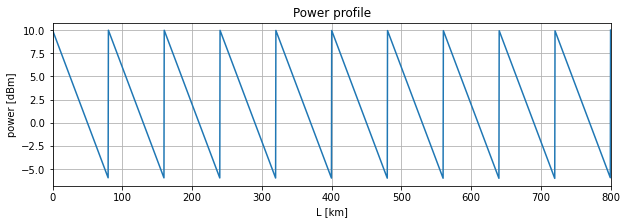

In [52]:
powerProfile(10, 0.2, 80, 10)